In [2]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "sum_wpm10_ex_q75_period1_2020,"+\
        "sum_wpm2p5_ex_q75_period1_2020,"+\
        "sum_wco_ex_q75_period1_2020,"+\
        "sum_wnh3_ex_q75_period1_2020,"+\
        "sum_wnmvoc_ex_q75_period1_2020,"+\
        "sum_wno2_ex_q75_period1_2020,"+\
        "sum_wno_ex_q75_period1_2020,"+\
        "sum_wo3_ex_q75_period1_2020,"+\
        "sum_wpans_ex_q75_period1_2020,"+\
        "sum_wso2_ex_q75_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [3]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   varese
   2   fermo
   3   sondrio
   4   bergamo
   5   pesaro
   6   siena
   7   pavia
   8   roma
   9   padova
   10   parma
   11   mantova
   12   crotone
   13   rimini
   14   viterbo
   15   messina
   16   gorizia
   17   ragusa
   18   bat
   19   catania
   20   grosseto
   21   arezzo
   22   rieti
   23   palermo
   24   forli
   25   macerata
   26   torino
   27   livorno
   28   reggio_nell_emilia
   29   campobasso
   30   avellino
   31   rovigo
   32   pescara
   33   agrigento
   34   genova
   35   teramo
   36   prato
   37   siracusa
   38   l_aquila
   39   cremona
   40   terni
   41   perugia
   42   enna
   43   piacenza
   44   modena
   45   como
   46   oristano
   47   foggia
   48   cuneo
   49   potenza
   50   belluno
   51   udine
   52   brescia
   53   vibo_valentia
   54   milano
   55   massa
   56   trento
   57   ancona
   58   savona
   59   imperia
   60   calta

In [4]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 varese
2 fermo
3 sondrio
4 bergamo
5 pesaro
6 siena
7 pavia
8 roma
9 padova
10 parma
11 mantova
12 crotone
13 rimini
14 viterbo
15 messina
16 gorizia
17 ragusa
18 bat
19 catania
20 grosseto
21 arezzo
22 rieti
23 palermo
24 forli
25 macerata
26 torino
27 livorno
28 reggio_nell_emilia
29 campobasso
30 avellino
31 rovigo
32 pescara
33 agrigento
34 genova
35 teramo
36 prato
37 siracusa
38 l_aquila
39 cremona
40 terni
41 perugia
42 enna
43 piacenza
44 modena
45 como
46 oristano
47 foggia
48 cuneo
49 potenza
50 belluno
51 udine
52 brescia
53 vibo_valentia
54 milano
55 massa
56 trento
57 ancona
58 savona
59 imperia
60 caltanissetta
61 asti
62 frosinone
63 vercelli
64 bolzano
65 ravenna
66 benevento
67 napoli
68 pistoia
69 trapani
70 bologna
71 pisa
72 cagliari
73 chieti
74 lucca
75 latina
76 ferrara
77 ascoli_piceno
78 alessandria
79 biella
80 verbania
81 nuoro
82 taranto
83 la_spezia
84 verona
85 monza
86 lecce
87 caserta
88 cosenza
89 bari
90 lecco
91 catanzaro
92 firenze
93 treviso
94 vi

In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.35515  0.02426 
    Test set average RMSE:  0.95637  0.09260 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.32695
                       R2:  0.95108


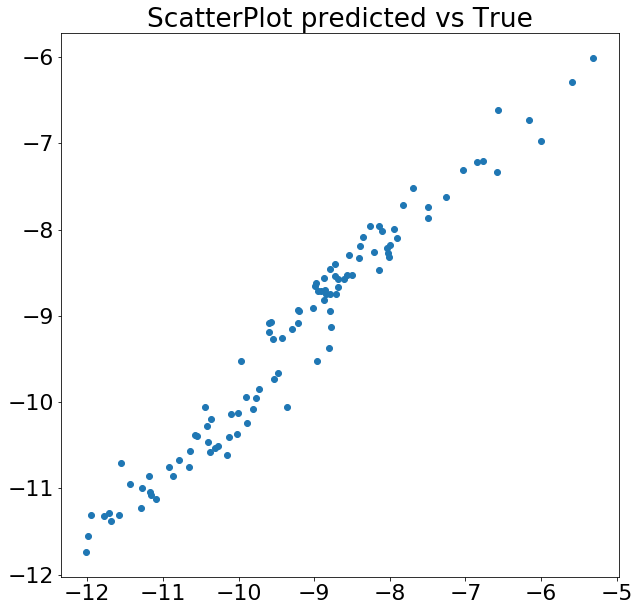

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.05493
Feature:               commutersdensity, Score: 0.03653
Feature:                         depriv, Score: 0.05985
Feature:                            lat, Score: 0.68208
Feature:                 Ratio0200ver65, Score: 0.08034
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02272
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02933
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02506
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00916


<Figure size 432x288 with 0 Axes>

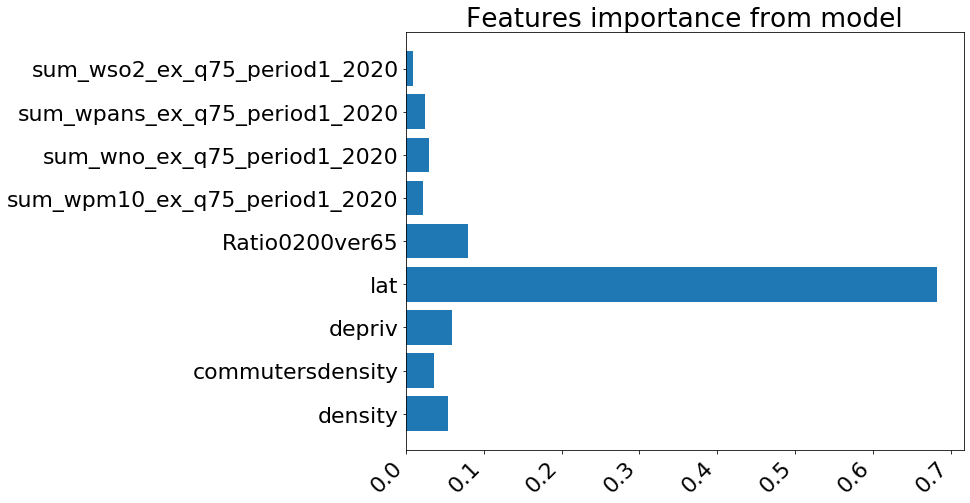

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.10608 +/- 0.00843
Feature:               commutersdensity, Score: 0.05766 +/- 0.00540
Feature:                         depriv, Score: 0.17126 +/- 0.01569
Feature:                            lat, Score: 3.26440 +/- 0.38894
Feature:                 Ratio0200ver65, Score: 0.22748 +/- 0.03337
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.05896 +/- 0.00880
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.06541 +/- 0.01508
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.06921 +/- 0.01469
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01692 +/- 0.00275


<Figure size 432x288 with 0 Axes>

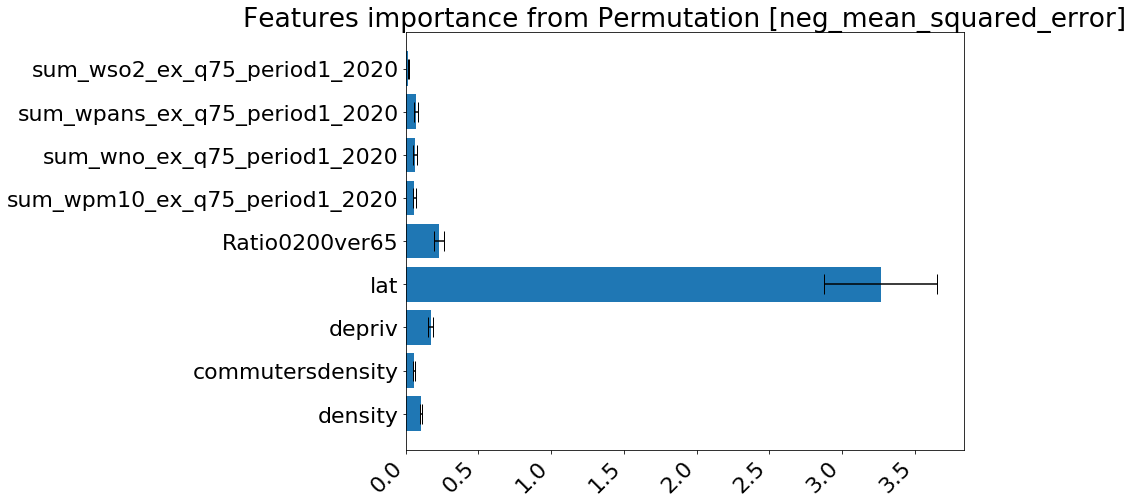

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.04855 +/- 0.00386
Feature:               commutersdensity, Score: 0.02638 +/- 0.00247
Feature:                         depriv, Score: 0.07837 +/- 0.00718
Feature:                            lat, Score: 1.49383 +/- 0.17798
Feature:                 Ratio0200ver65, Score: 0.10410 +/- 0.01527
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02698 +/- 0.00403
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02993 +/- 0.00690
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.03167 +/- 0.00672
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00774 +/- 0.00126


<Figure size 432x288 with 0 Axes>

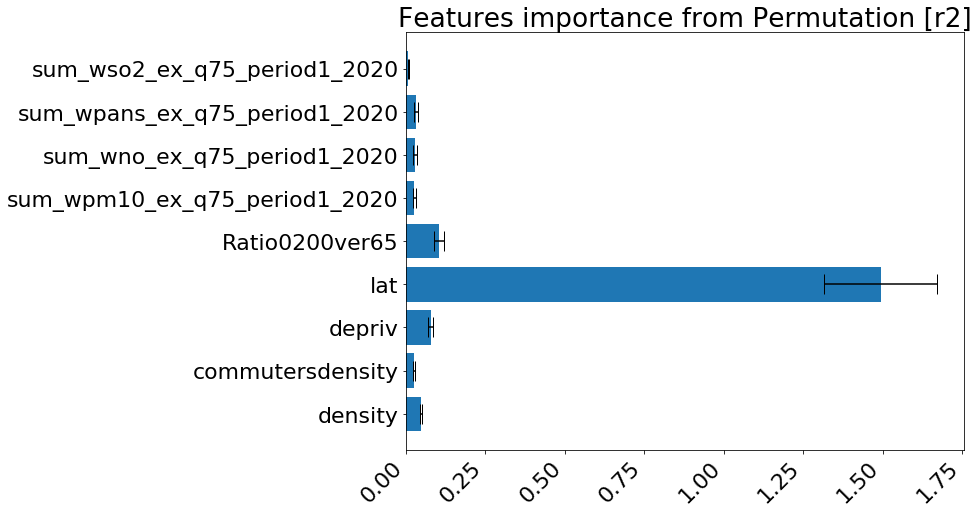

<Figure size 720x720 with 0 Axes>

((0.3551533581281817, 0.024258558093507528),
 (0.9563669203886902, 0.09259898863774141),
 0.3269500376513558,
 {'density': 0.026275594083322567,
  'commutersdensity': 0.014280937244929449,
  'depriv': 0.04241901910400325,
  'lat': 0.8085439665546409,
  'Ratio0200ver65': 0.05634304374922896,
  'sum_wpm10_ex_q75_period1_2020': 0.014603101232261653,
  'sum_wno_ex_q75_period1_2020': 0.016201798063333876,
  'sum_wpans_ex_q75_period1_2020': 0.017142773433611792,
  'sum_wso2_ex_q75_period1_2020': 0.00418976653466773},
 {'density': 0.026275594083322563,
  'commutersdensity': 0.014280937244929435,
  'depriv': 0.042419019104003246,
  'lat': 0.8085439665546409,
  'Ratio0200ver65': 0.05634304374922896,
  'sum_wpm10_ex_q75_period1_2020': 0.014603101232261646,
  'sum_wno_ex_q75_period1_2020': 0.01620179806333387,
  'sum_wpans_ex_q75_period1_2020': 0.017142773433611775,
  'sum_wso2_ex_q75_period1_2020': 0.0041897665346677234})

In [6]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_allfeatures_using_sum", pout=sys.stdout, showplot=True)

In [7]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.10689632712022296
2  of  1200 MSE:  0.10562113139785265
3  of  1200 MSE:  0.1805520656543431
4  of  1200 MSE:  0.24383033125775933
5  of  1200 MSE:  0.4324144989322188
6  of  1200 MSE:  0.5141634481498832
7  of  1200 MSE:  0.6100612545679615
8  of  1200 MSE:  0.6869787274056146
9  of  1200 MSE:  0.17639355805368473
10  of  1200 MSE:  0.21237131029103595
11  of  1200 MSE:  0.20954474626678785
12  of  1200 MSE:  0.2668352128237069
13  of  1200 MSE:  0.4324144989322188
14  of  1200 MSE:  0.5141634481498832
15  of  1200 MSE:  0.6100612545679615
16  of  1200 MSE:  0.6869787274056146
17  of  1200 MSE:  0.32473115022083465
18  of  1200 MSE:  0.39528104899382355
19  of  1200 MSE:  0.3460493548996676
20  of  1200 MSE:  0.4261098781192919
21  of  1200 MSE:  0.4324144989322188
22  of  1200 MSE:  0.5141634481498832
23  of  1200 MSE:  0.6100612545679615
24  of  1200 MSE:  0.6869787274056146
25  of  1200 MSE:  0.4322528103769693
26  of  1200 MSE:  0.4962156202917744
27  of  1200 

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 1}
Training set average RMSE:  0.35226  0.02420 
    Test set average RMSE:  0.93581  0.10462 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.32499
                       R2:  0.95167


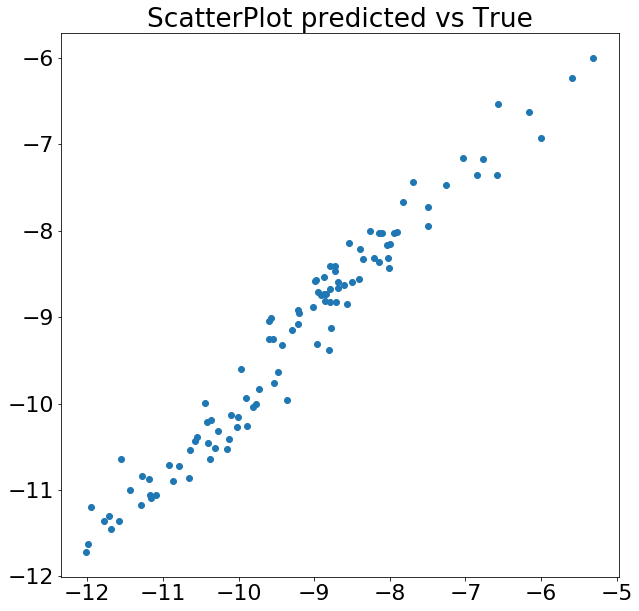

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.06675
Feature:               commutersdensity, Score: 0.20023
Feature:                         depriv, Score: 0.13839
Feature:                            lat, Score: 0.33645
Feature:                 Ratio0200ver65, Score: 0.09534
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.08122
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03574
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02850
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01738


<Figure size 432x288 with 0 Axes>

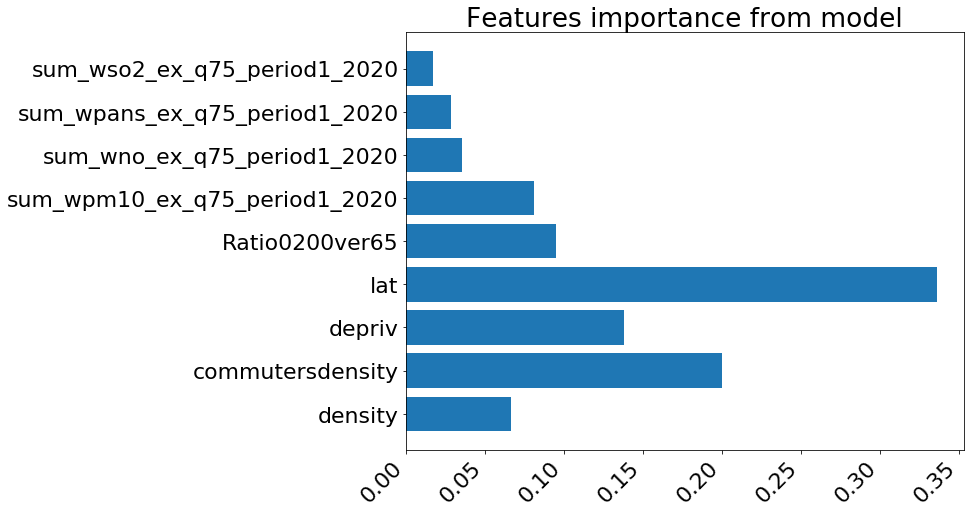

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.11577 +/- 0.01193
Feature:               commutersdensity, Score: 0.06391 +/- 0.00623
Feature:                         depriv, Score: 0.14462 +/- 0.01175
Feature:                            lat, Score: 3.27610 +/- 0.38788
Feature:                 Ratio0200ver65, Score: 0.21498 +/- 0.03208
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.07032 +/- 0.01052
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.08229 +/- 0.01701
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.07319 +/- 0.01649
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01274 +/- 0.00266


<Figure size 432x288 with 0 Axes>

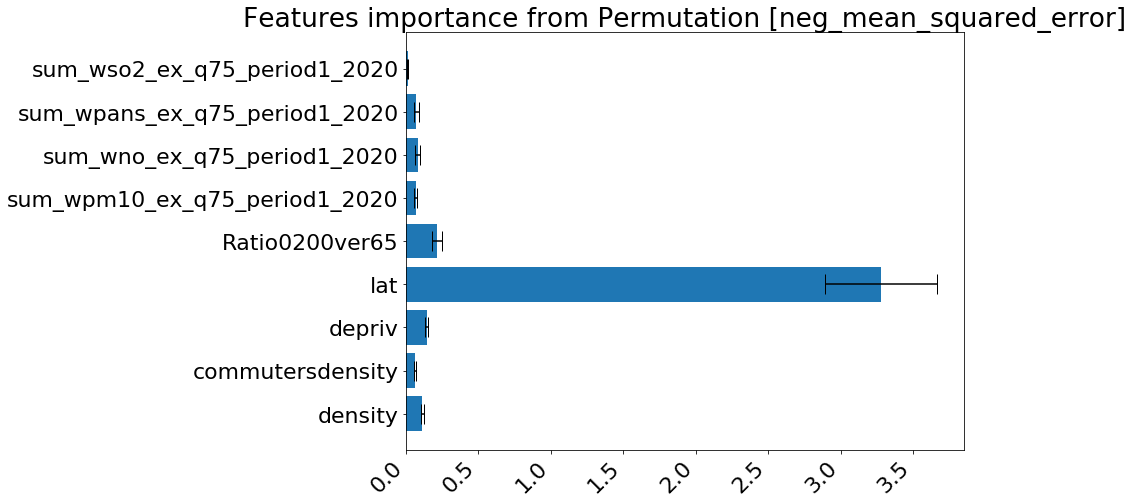

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.05298 +/- 0.00546
Feature:               commutersdensity, Score: 0.02925 +/- 0.00285
Feature:                         depriv, Score: 0.06618 +/- 0.00538
Feature:                            lat, Score: 1.49919 +/- 0.17750
Feature:                 Ratio0200ver65, Score: 0.09838 +/- 0.01468
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.03218 +/- 0.00482
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03766 +/- 0.00778
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.03349 +/- 0.00755
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00583 +/- 0.00122


<Figure size 432x288 with 0 Axes>

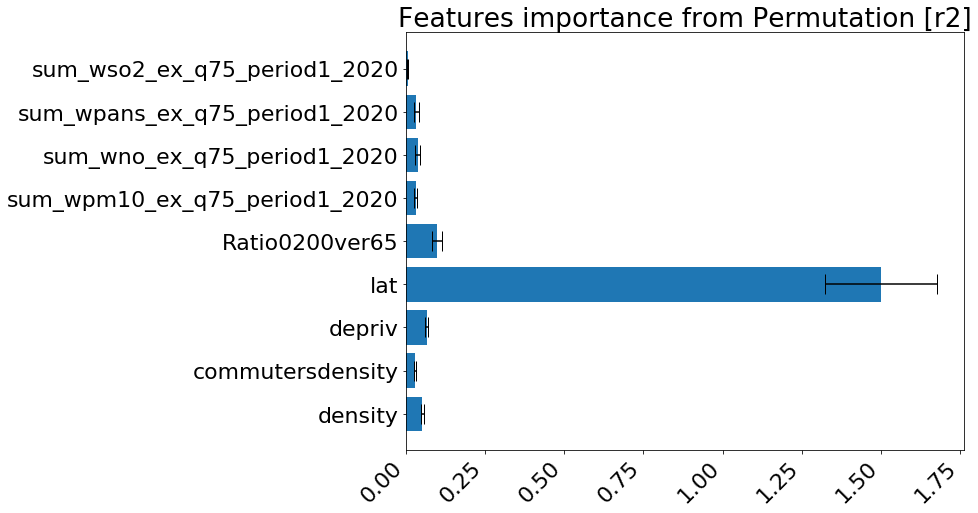

<Figure size 720x720 with 0 Axes>

((0.352264399998414, 0.02419522693193029),
 (0.9358137309420371, 0.10462478597957947),
 0.32499404824989125,
 {'density': 0.028558368903249486,
  'commutersdensity': 0.0157661624523532,
  'depriv': 0.03567413396539923,
  'lat': 0.8081307418929627,
  'Ratio0200ver65': 0.053029320656569304,
  'sum_wpm10_ex_q75_period1_2020': 0.017345143106725462,
  'sum_wno_ex_q75_period1_2020': 0.020299880681925227,
  'sum_wpans_ex_q75_period1_2020': 0.01805299711925491,
  'sum_wso2_ex_q75_period1_2020': 0.003143251221560318},
 {'density': 0.02855836890324948,
  'commutersdensity': 0.0157661624523532,
  'depriv': 0.03567413396539923,
  'lat': 0.8081307418929629,
  'Ratio0200ver65': 0.053029320656569304,
  'sum_wpm10_ex_q75_period1_2020': 0.01734514310672546,
  'sum_wno_ex_q75_period1_2020': 0.020299880681925227,
  'sum_wpans_ex_q75_period1_2020': 0.01805299711925491,
  'sum_wso2_ex_q75_period1_2020': 0.0031432512215603123})

In [8]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt_using_sum",showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.38608  0.03701 
    Test set average RMSE:  1.04824  0.12466 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36434
                       R2:  0.93925


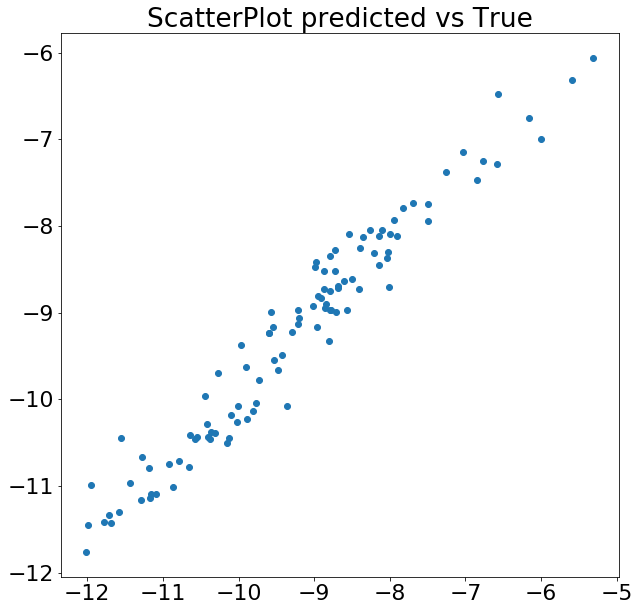

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.07856
Feature:               commutersdensity, Score: 0.53166
Feature:                         depriv, Score: 0.08345
Feature:                 Ratio0200ver65, Score: 0.15317
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.05355
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03560
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.03694
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02706


<Figure size 432x288 with 0 Axes>

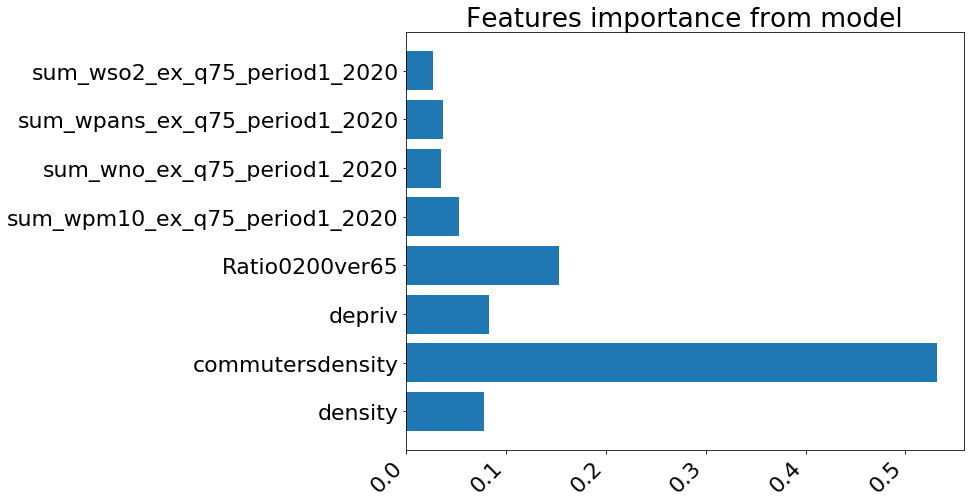

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.17140 +/- 0.01911
Feature:               commutersdensity, Score: 2.16676 +/- 0.33019
Feature:                         depriv, Score: 0.20993 +/- 0.02082
Feature:                 Ratio0200ver65, Score: 0.38399 +/- 0.04698
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.19867 +/- 0.03604
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.07789 +/- 0.01888
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.12027 +/- 0.01836
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.04799 +/- 0.00935


<Figure size 432x288 with 0 Axes>

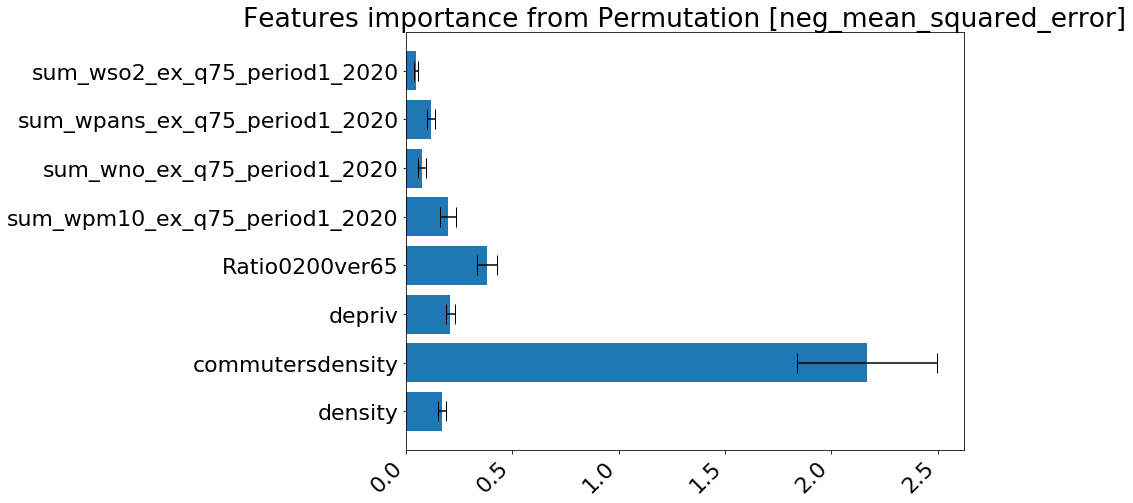

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.07843 +/- 0.00875
Feature:               commutersdensity, Score: 0.99154 +/- 0.15110
Feature:                         depriv, Score: 0.09607 +/- 0.00953
Feature:                 Ratio0200ver65, Score: 0.17572 +/- 0.02150
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.09091 +/- 0.01649
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03564 +/- 0.00864
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.05504 +/- 0.00840
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02196 +/- 0.00428


<Figure size 432x288 with 0 Axes>

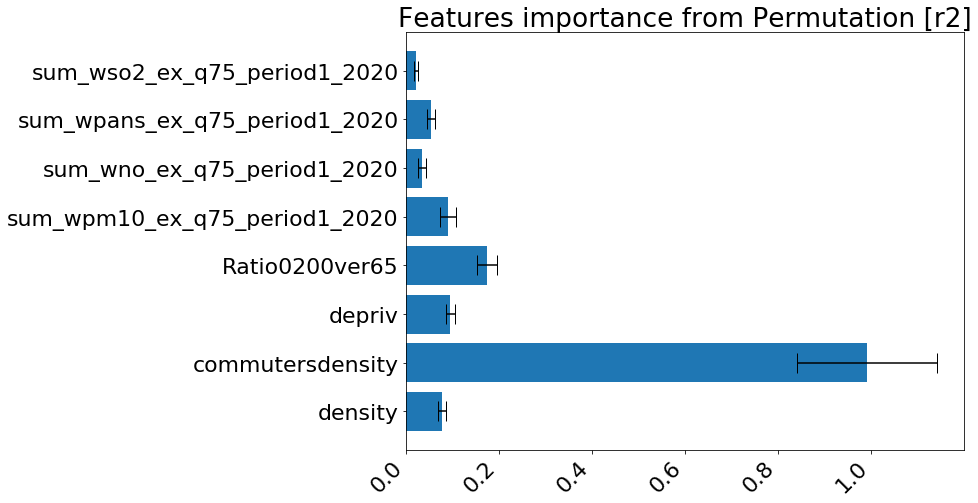

<Figure size 720x720 with 0 Axes>

((0.3860765033905224, 0.03700710538103553),
 (1.048243412034668, 0.12465913964671835),
 0.3643414628631665,
 {'density': 0.05075628820314202,
  'commutersdensity': 0.6416411929191039,
  'depriv': 0.06216746119949163,
  'Ratio0200ver65': 0.11371124800476064,
  'sum_wpm10_ex_q75_period1_2020': 0.0588321926581769,
  'sum_wno_ex_q75_period1_2020': 0.023065805197043106,
  'sum_wpans_ex_q75_period1_2020': 0.035614813351298506,
  'sum_wso2_ex_q75_period1_2020': 0.014210998466983267},
 {'density': 0.050756288203142055,
  'commutersdensity': 0.6416411929191038,
  'depriv': 0.062167461199491646,
  'Ratio0200ver65': 0.11371124800476066,
  'sum_wpm10_ex_q75_period1_2020': 0.05883219265817691,
  'sum_wno_ex_q75_period1_2020': 0.023065805197043127,
  'sum_wpans_ex_q75_period1_2020': 0.03561481335129852,
  'sum_wso2_ex_q75_period1_2020': 0.014210998466983295})

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_using_sum", pout=sys.stdout, showplot=True)

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.1327447015612721
2  of  1200 MSE:  0.1238697204722796
3  of  1200 MSE:  0.22671199102482756
4  of  1200 MSE:  0.34217628270383393
5  of  1200 MSE:  0.5400865084051876
6  of  1200 MSE:  0.6782470176720818
7  of  1200 MSE:  0.7721154485876435
8  of  1200 MSE:  0.8709239671463528
9  of  1200 MSE:  0.21355322503930266
10  of  1200 MSE:  0.29335493000421553
11  of  1200 MSE:  0.25988153176853035
12  of  1200 MSE:  0.3802391211332009
13  of  1200 MSE:  0.5400865084051876
14  of  1200 MSE:  0.6782470176720818
15  of  1200 MSE:  0.7721154485876435
16  of  1200 MSE:  0.8709239671463528
17  of  1200 MSE:  0.39596100026526215
18  of  1200 MSE:  0.5053493215616777
19  of  1200 MSE:  0.4228358862494811
20  of  1200 MSE:  0.5552175532534724
21  of  1200 MSE:  0.5400865084051876
22  of  1200 MSE:  0.6782470176720818
23  of  1200 MSE:  0.7721154485876435
24  of  1200 MSE:  0.8709239671463528
25  of  1200 MSE:  0.5258445172055928
26  of  1200 MSE:  0.6399053591972582
27  of  1200 MS

Training set average RMSE:  0.36977  0.02265 
    Test set average RMSE:  1.03328  0.10649 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35195
                       R2:  0.94332


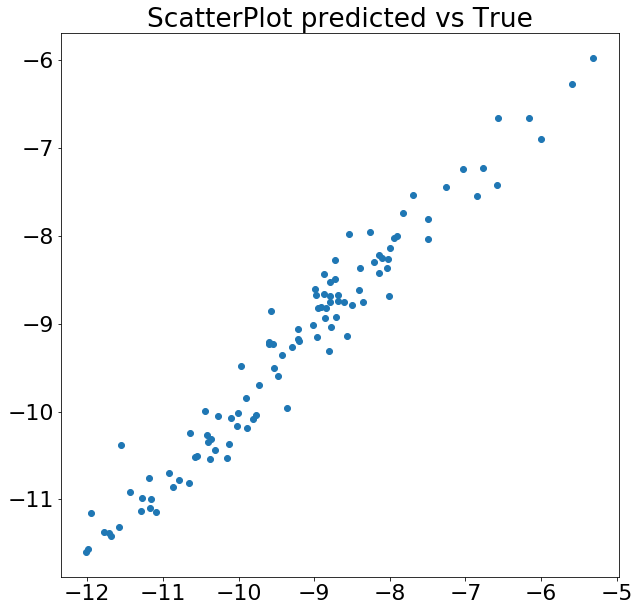

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.11515
Feature:               commutersdensity, Score: 0.26052
Feature:                         depriv, Score: 0.21660
Feature:                 Ratio0200ver65, Score: 0.12941
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.15116
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.04287
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.03763
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.04665


<Figure size 432x288 with 0 Axes>

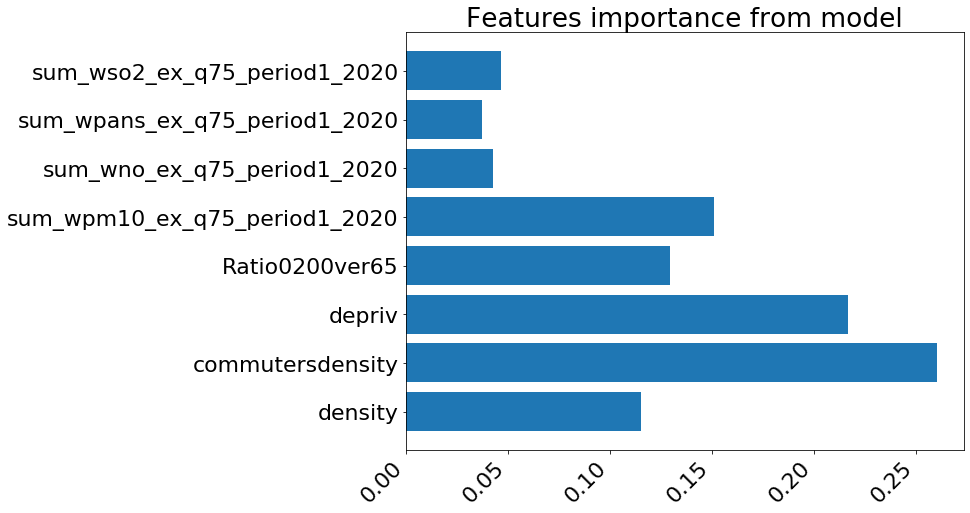

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.15454 +/- 0.01501
Feature:               commutersdensity, Score: 2.21424 +/- 0.33737
Feature:                         depriv, Score: 0.23348 +/- 0.02095
Feature:                 Ratio0200ver65, Score: 0.37816 +/- 0.04455
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.21831 +/- 0.04426
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.06848 +/- 0.01543
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.11967 +/- 0.02018
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.05142 +/- 0.00919


<Figure size 432x288 with 0 Axes>

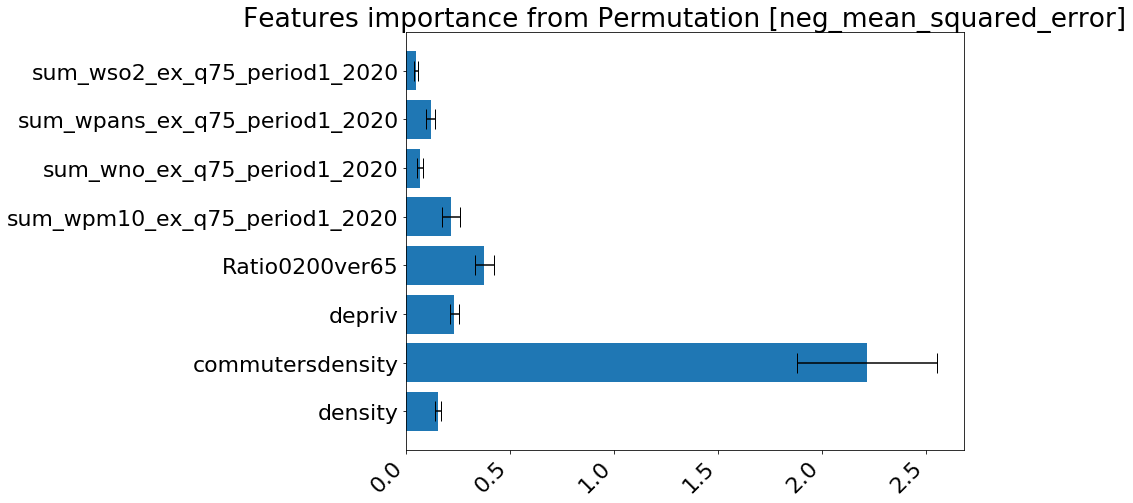

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.07072 +/- 0.00687
Feature:               commutersdensity, Score: 1.01327 +/- 0.15438
Feature:                         depriv, Score: 0.10684 +/- 0.00959
Feature:                 Ratio0200ver65, Score: 0.17305 +/- 0.02039
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.09990 +/- 0.02025
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03134 +/- 0.00706
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.05476 +/- 0.00923
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02353 +/- 0.00420


<Figure size 432x288 with 0 Axes>

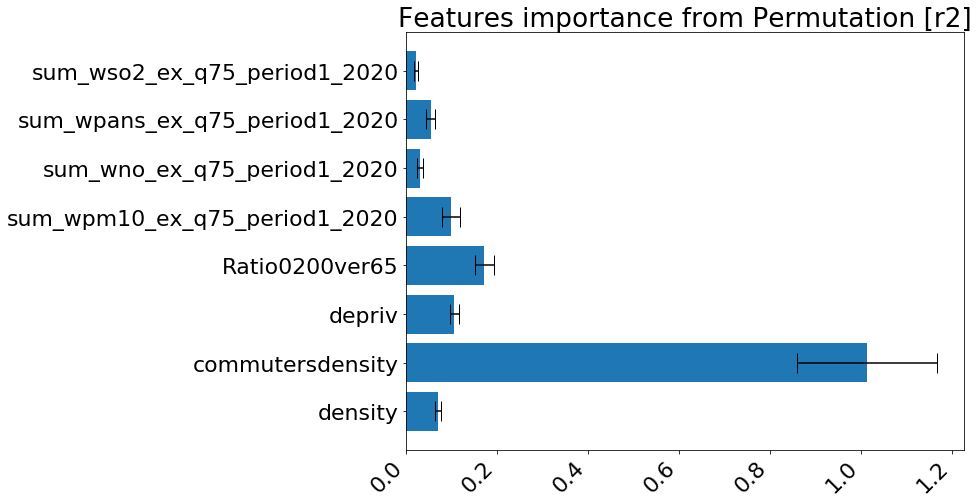

<Figure size 720x720 with 0 Axes>

((0.36977432116026526, 0.02264684931769393),
 (1.0332820449911606, 0.10648957547226164),
 0.3519513041207258,
 {'density': 0.04494556155767264,
  'commutersdensity': 0.6439937735831843,
  'depriv': 0.06790604459684227,
  'Ratio0200ver65': 0.10998502642090267,
  'sum_wpm10_ex_q75_period1_2020': 0.06349467464554774,
  'sum_wno_ex_q75_period1_2020': 0.01991702698452254,
  'sum_wpans_ex_q75_period1_2020': 0.034803903619944274,
  'sum_wso2_ex_q75_period1_2020': 0.014953988591383683},
 {'density': 0.04494556155767263,
  'commutersdensity': 0.6439937735831842,
  'depriv': 0.06790604459684224,
  'Ratio0200ver65': 0.10998502642090265,
  'sum_wpm10_ex_q75_period1_2020': 0.06349467464554773,
  'sum_wno_ex_q75_period1_2020': 0.01991702698452254,
  'sum_wpans_ex_q75_period1_2020': 0.03480390361994427,
  'sum_wso2_ex_q75_period1_2020': 0.01495398859138368})

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt_using_sum", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.41774  0.02816 
    Test set average RMSE:  1.11053  0.12439 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36650
                       R2:  0.93853


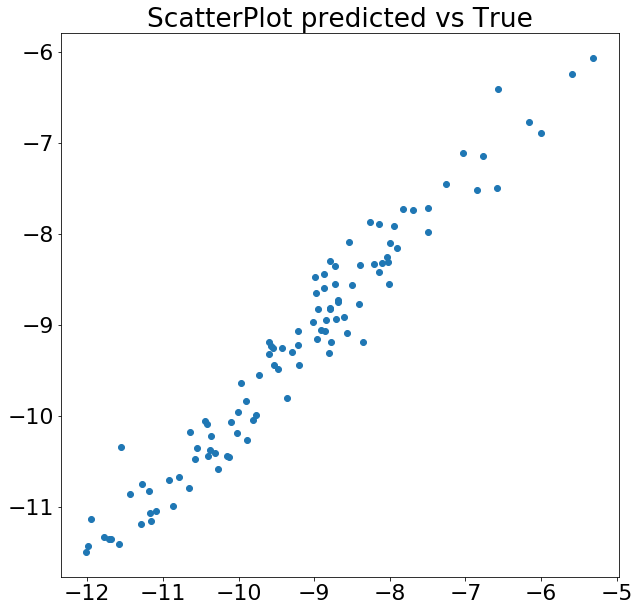

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.11870
Feature:                         depriv, Score: 0.36022
Feature:                 Ratio0200ver65, Score: 0.16816
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.24583
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01874
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.04221
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.04614


<Figure size 432x288 with 0 Axes>

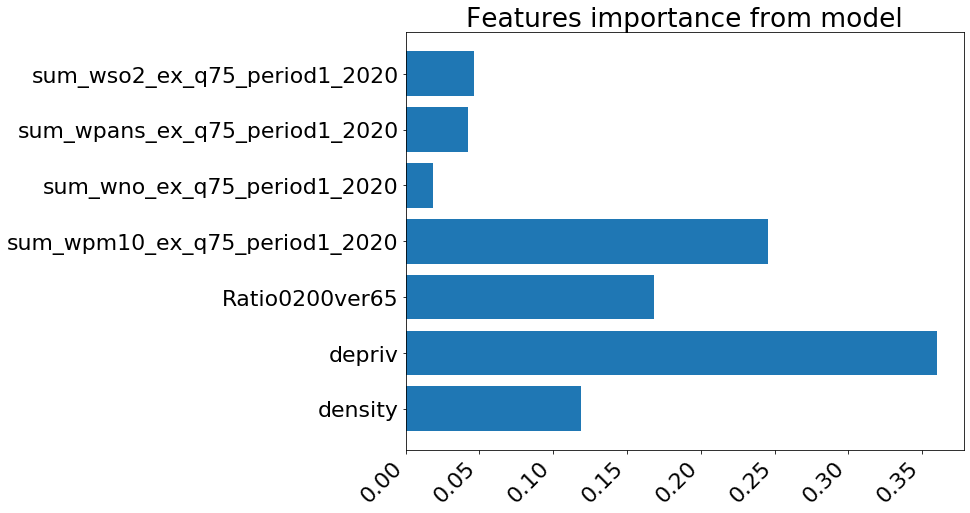

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.27208 +/- 0.02775
Feature:                         depriv, Score: 1.17152 +/- 0.15659
Feature:                 Ratio0200ver65, Score: 0.38587 +/- 0.04917
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.89930 +/- 0.14348
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.04265 +/- 0.00924
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.12586 +/- 0.01969
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.10129 +/- 0.01688


<Figure size 432x288 with 0 Axes>

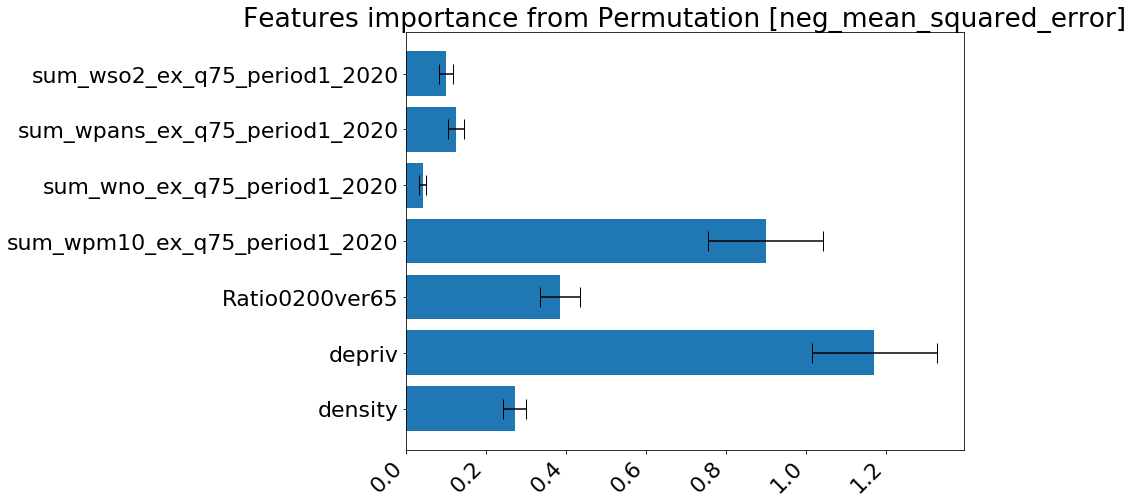

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.12451 +/- 0.01270
Feature:                         depriv, Score: 0.53610 +/- 0.07166
Feature:                 Ratio0200ver65, Score: 0.17658 +/- 0.02250
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.41153 +/- 0.06566
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01952 +/- 0.00423
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.05760 +/- 0.00901
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.04635 +/- 0.00772


<Figure size 432x288 with 0 Axes>

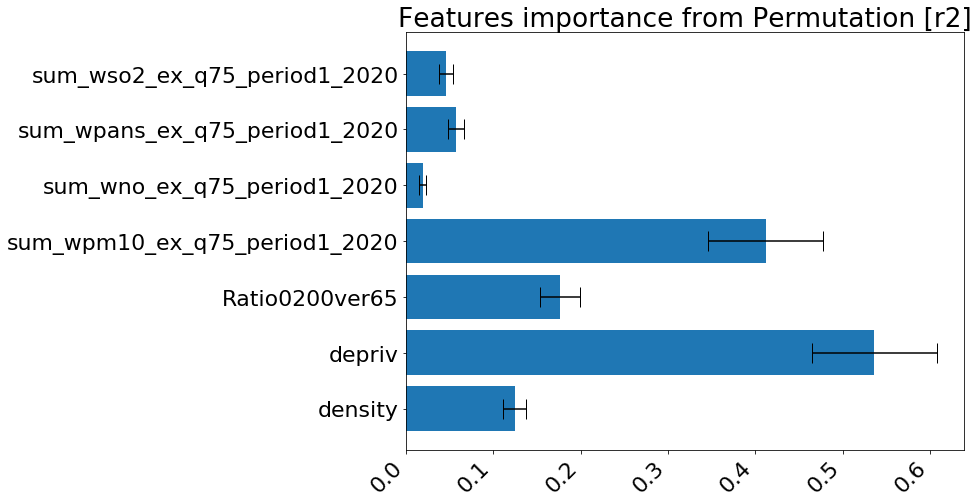

<Figure size 720x720 with 0 Axes>

((0.4177385061393419, 0.028155058745554466),
 (1.1105319834149219, 0.12439260045714302),
 0.3665005953252788,
 {'density': 0.09073687429505332,
  'depriv': 0.39068978807800037,
  'Ratio0200ver65': 0.1286857000553932,
  'sum_wpm10_ex_q75_period1_2020': 0.29990981088789914,
  'sum_wno_ex_q75_period1_2020': 0.01422286731873224,
  'sum_wpans_ex_q75_period1_2020': 0.041974604160271566,
  'sum_wso2_ex_q75_period1_2020': 0.033780355204650205},
 {'density': 0.09073687429505331,
  'depriv': 0.39068978807800037,
  'Ratio0200ver65': 0.1286857000553932,
  'sum_wpm10_ex_q75_period1_2020': 0.29990981088789903,
  'sum_wno_ex_q75_period1_2020': 0.01422286731873223,
  'sum_wpans_ex_q75_period1_2020': 0.041974604160271545,
  'sum_wso2_ex_q75_period1_2020': 0.03378035520465021})

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocom_using_sum", pout=sys.stdout, showplot=True)

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.13432268637378378
2  of  1200 MSE:  0.13494718135317366
3  of  1200 MSE:  0.2561688917653095
4  of  1200 MSE:  0.3778848982142644
5  of  1200 MSE:  0.6243331671299117
6  of  1200 MSE:  0.7420257502594728
7  of  1200 MSE:  0.890171573934339
8  of  1200 MSE:  0.9815965386933759
9  of  1200 MSE:  0.23599184070355517
10  of  1200 MSE:  0.2966218591563941
11  of  1200 MSE:  0.2938844126857892
12  of  1200 MSE:  0.41925465078037816
13  of  1200 MSE:  0.6243331671299117
14  of  1200 MSE:  0.7420257502594728
15  of  1200 MSE:  0.890171573934339
16  of  1200 MSE:  0.9815965386933759
17  of  1200 MSE:  0.4174551471977375
18  of  1200 MSE:  0.5646114250273715
19  of  1200 MSE:  0.46053129435304224
20  of  1200 MSE:  0.6076925750443439
21  of  1200 MSE:  0.6243331671299117
22  of  1200 MSE:  0.7420257502594728
23  of  1200 MSE:  0.890171573934339
24  of  1200 MSE:  0.9815965386933759
25  of  1200 MSE:  0.5766144828784483
26  of  1200 MSE:  0.6884395897944859
27  of  1200 MSE:  

Training set average RMSE:  0.38239  0.02799 
    Test set average RMSE:  1.06136  0.11584 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35708
                       R2:  0.94165


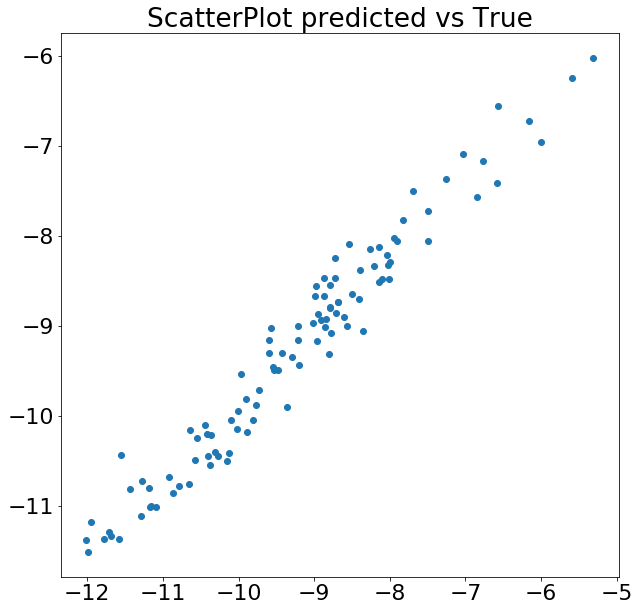

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.15638
Feature:                         depriv, Score: 0.29305
Feature:                 Ratio0200ver65, Score: 0.16751
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.18254
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.06605
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.05715
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.07732


<Figure size 432x288 with 0 Axes>

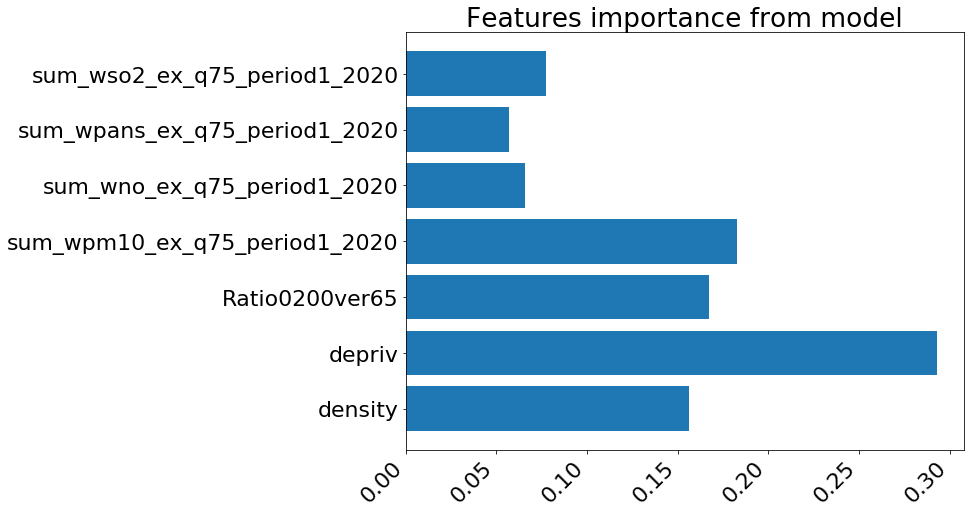

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.27947 +/- 0.02819
Feature:                         depriv, Score: 1.26478 +/- 0.17105
Feature:                 Ratio0200ver65, Score: 0.43379 +/- 0.05637
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.78221 +/- 0.12999
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03028 +/- 0.00600
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.12054 +/- 0.02005
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.11135 +/- 0.02082


<Figure size 432x288 with 0 Axes>

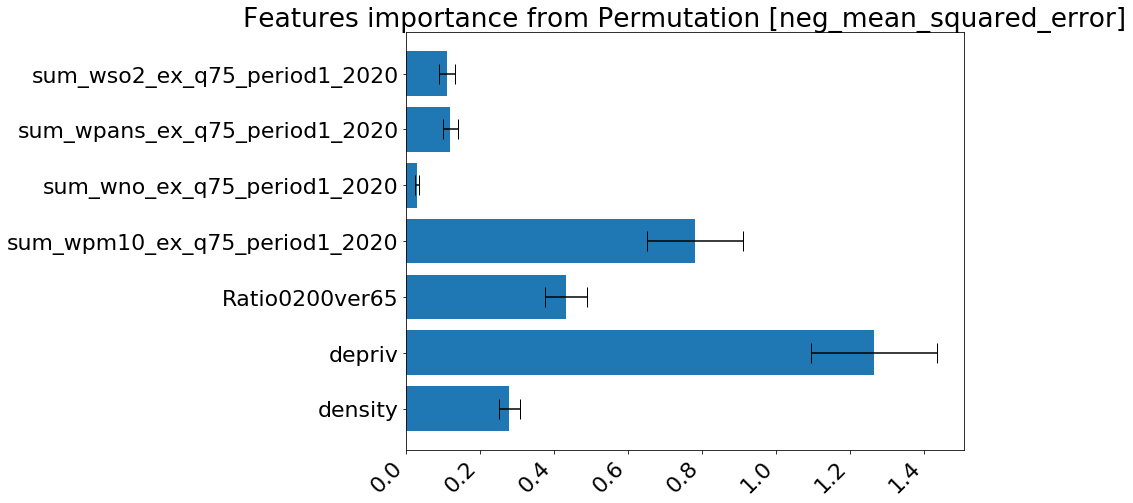

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.12789 +/- 0.01290
Feature:                         depriv, Score: 0.57878 +/- 0.07828
Feature:                 Ratio0200ver65, Score: 0.19851 +/- 0.02580
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.35795 +/- 0.05949
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01386 +/- 0.00275
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.05516 +/- 0.00917
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.05095 +/- 0.00953


<Figure size 432x288 with 0 Axes>

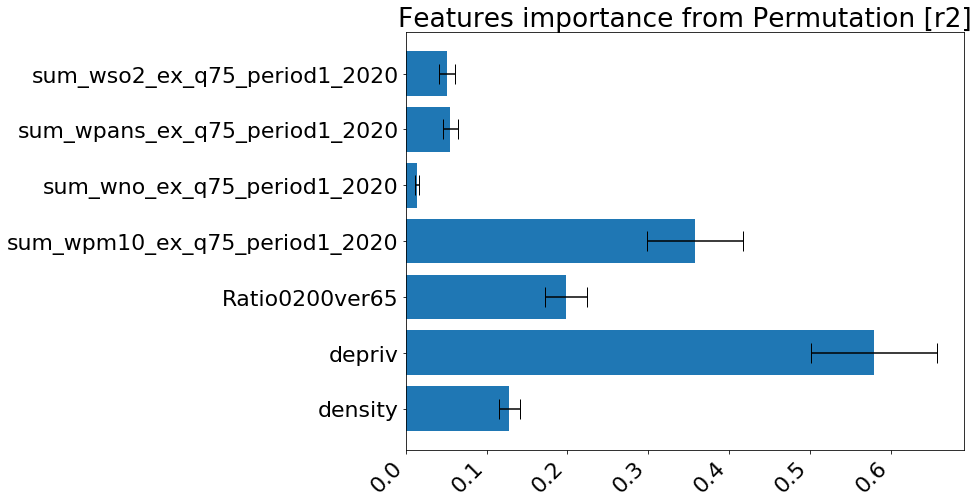

<Figure size 720x720 with 0 Axes>

((0.38238810808152507, 0.027988801918536158),
 (1.0613562414514872, 0.1158431417173409),
 0.35708039885154386,
 {'density': 0.09246730990299927,
  'depriv': 0.41846696550545204,
  'Ratio0200ver65': 0.14352330249623887,
  'sum_wpm10_ex_q75_period1_2020': 0.2588033241396926,
  'sum_wno_ex_q75_period1_2020': 0.010018952453547099,
  'sum_wpans_ex_q75_period1_2020': 0.03988043606554167,
  'sum_wso2_ex_q75_period1_2020': 0.036839709436528326},
 {'density': 0.09246730990299926,
  'depriv': 0.41846696550545215,
  'Ratio0200ver65': 0.1435233024962389,
  'sum_wpm10_ex_q75_period1_2020': 0.2588033241396926,
  'sum_wno_ex_q75_period1_2020': 0.010018952453547083,
  'sum_wpans_ex_q75_period1_2020': 0.03988043606554166,
  'sum_wso2_ex_q75_period1_2020': 0.03683970943652832})

In [14]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocom_opt_using_sum", showplot=True, optimisedparams=bestf)